## Deleterious variant simulations & comparison to theory

In [1]:
from scipy.special import erfinv
from scipy.special import loggamma
from scipy.stats import gamma
from scipy.stats import nbinom
from scipy import special
import numpy as np
import sys
import math
sys.path.insert(1,'numerics_snakemake')
from plot_sfs import *
from matplotlib import pyplot as plt
from power_v2 import *
from plot_expseg import *
import seaborn as sns
from matplotlib import colors as mcolors
from matplotlib import cm as cm
import random
from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter
from scipy.special import binom
import inspect
random.seed(1234)
colors = sns.color_palette("colorblind", 8)
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'font.sans-serif': 'Helvetica'})
# plt.rcParams.update({'figure.figsize': '10,8'})
plt.rcParams.update({'lines.linewidth': 6})
plt.rcParams.update({'lines.markersize': 12})

### Functions for simulations

In [2]:
def simulate_WF(m,dims,pop_size,s,num_intervals):
    # create array of (num_intervals) matrices each with dimensions given by dims
    output = np.zeros(tuple([num_intervals]) + dims)
    # for positive value of s, interval size is 1/s
    if s > 0:
        interval = int(1 / s)
    else: # if s=0, interval=100
        interval = 100
    # number of generations to simulate
    num_gens = interval * num_intervals
    # create array to store frequencies
    f = np.zeros(dims)
    # choose random deme & initialize variant there
    # *this is changed from old version - was always initialized in the same place*
    rand_x, rand_y = random.randint(0, dims[0] - 1), random.randint(0, dims[1] - 1)
    # initialize at frequency 1/N
    f[rand_x, rand_y] = 1 / pop_size
    ## pre-allocate list of when reset happens
    reset_gens = []
    for i in range(num_gens):
        # Wright-Fisher diffusion w/Stepping Stone migration
        df = - s * f * (1 - f) + m * laplace(f, mode='wrap')
        # bounds allele frequencies in [0,1]
        p = np.clip(a=f + df, a_min=0, a_max=1)
        # binomial sampling from frequencies
        new_f = np.random.binomial(pop_size, p) / pop_size
        # Check for extinct allele
        if np.all(new_f == 0):
            ## if extinct, store previous freqs and reset
            reset_gens.append(i)
            ## Initialize new allele
            rand_x, rand_y = random.randint(0, dims[0] - 1), random.randint(0, dims[1] - 1)
            new_f[rand_x, rand_y] = 1 / pop_size
        # Assign next frequencies
        f = new_f
        # store freqs every 1/s
        if (i + 1) % interval == 0:
            output[i // interval] = f
    return output

def sample_f(f,sigma):
    # values of sigma to sample - from 1 to width of grid
    sig_arr =  [sigma]#np.arange(f.shape[-1])+1
    # create array with copy of f for each entry in sig_arr
    f_filt = np.zeros((tuple([len(sig_arr)])+f.shape))
    # iterate over values of sigma
    for i,sig in enumerate(sig_arr):
        # for each entry in matrix
        for j in range(f.shape[0]):
            for k in range(f.shape[1]):
                # frequency stored in f_filt is gaussian filter applied to frequency in f
                # sigma defines width of kernel
                f_filt[i,j,k]=gaussian_filter(f[j,k],sigma=sig,mode="wrap")
    return f_filt

def freq_sfs(f,n,nbins):
    # create array to store entries of sfs
    sfs = np.zeros(tuple([nbins + 1]) + f.shape)
    # iterate over entries in sfs
    for j in range(nbins + 1):
        # calculate SFS entry from frequency using binomial sampling
        sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
    return sfs

def get_sfs(f,sigma,n,nbins=100):
    # sample from f with range of sigma
    f_filt = sample_f(f,sigma)
    # j is allele count, range 1 to n
    j = np.arange(1,n+1) # ignore j=0
    # average sampled f over intervals,reps, dims
    sfs = freq_sfs(f_filt,n,nbins).T
    # avg over both spatial dimensions & generations
    sfs_avg = np.mean(sfs,axis=(0,1,2))
    return j, sfs_avg[0,1:]

### Functions for theory

In [3]:
def finite_sfs_k(n,k,sigma,s,sigma_vals,pole_vals,res_vals,mu=1e-8,dens=100,D=1,d=2):
    beta = rate_p(sigma,s,sigma_vals,pole_vals,dens,D,d)
    alpha = shape_p(sigma,s,sigma_vals,res_vals,mu,dens,D,d)
    logval = k*np.log(n)+alpha*np.log(beta)-(k+alpha)*np.log(n+beta)+loggamma(k+alpha)-loggamma(k+1)-loggamma(alpha)
    return(np.e**logval)

### Tests

In [4]:
# load data
data = pd.read_csv("numerics_snakemake/spatial_integrals_dim2.csv")
data_pr = pd.read_csv("numerics_snakemake/cleaned_data_dim2_errorFalse.csv")
data_pr = data_pr.loc[data_pr['poly_type'] == '1_1']

sigma_vals = data['sigma'].tolist()
kappa_list = data['u2_GQ'].tolist()
res_vals = data_pr['residues']
pole_vals = data_pr['poles']

### Theory vs. simulation

In [5]:
s_vals = np.logspace(-1,-8,8)
mu = 1e-8
rho = 1000 # density
D = 1 # dispersal distance
Nb = 4*np.pi*(D**2)*rho 
l = np.sqrt(Nb/rho)
m = D/(l**2)

nmax = 100
sg= [1,10,100]

dims = (50,50)
num_intervals = 100

<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipyth

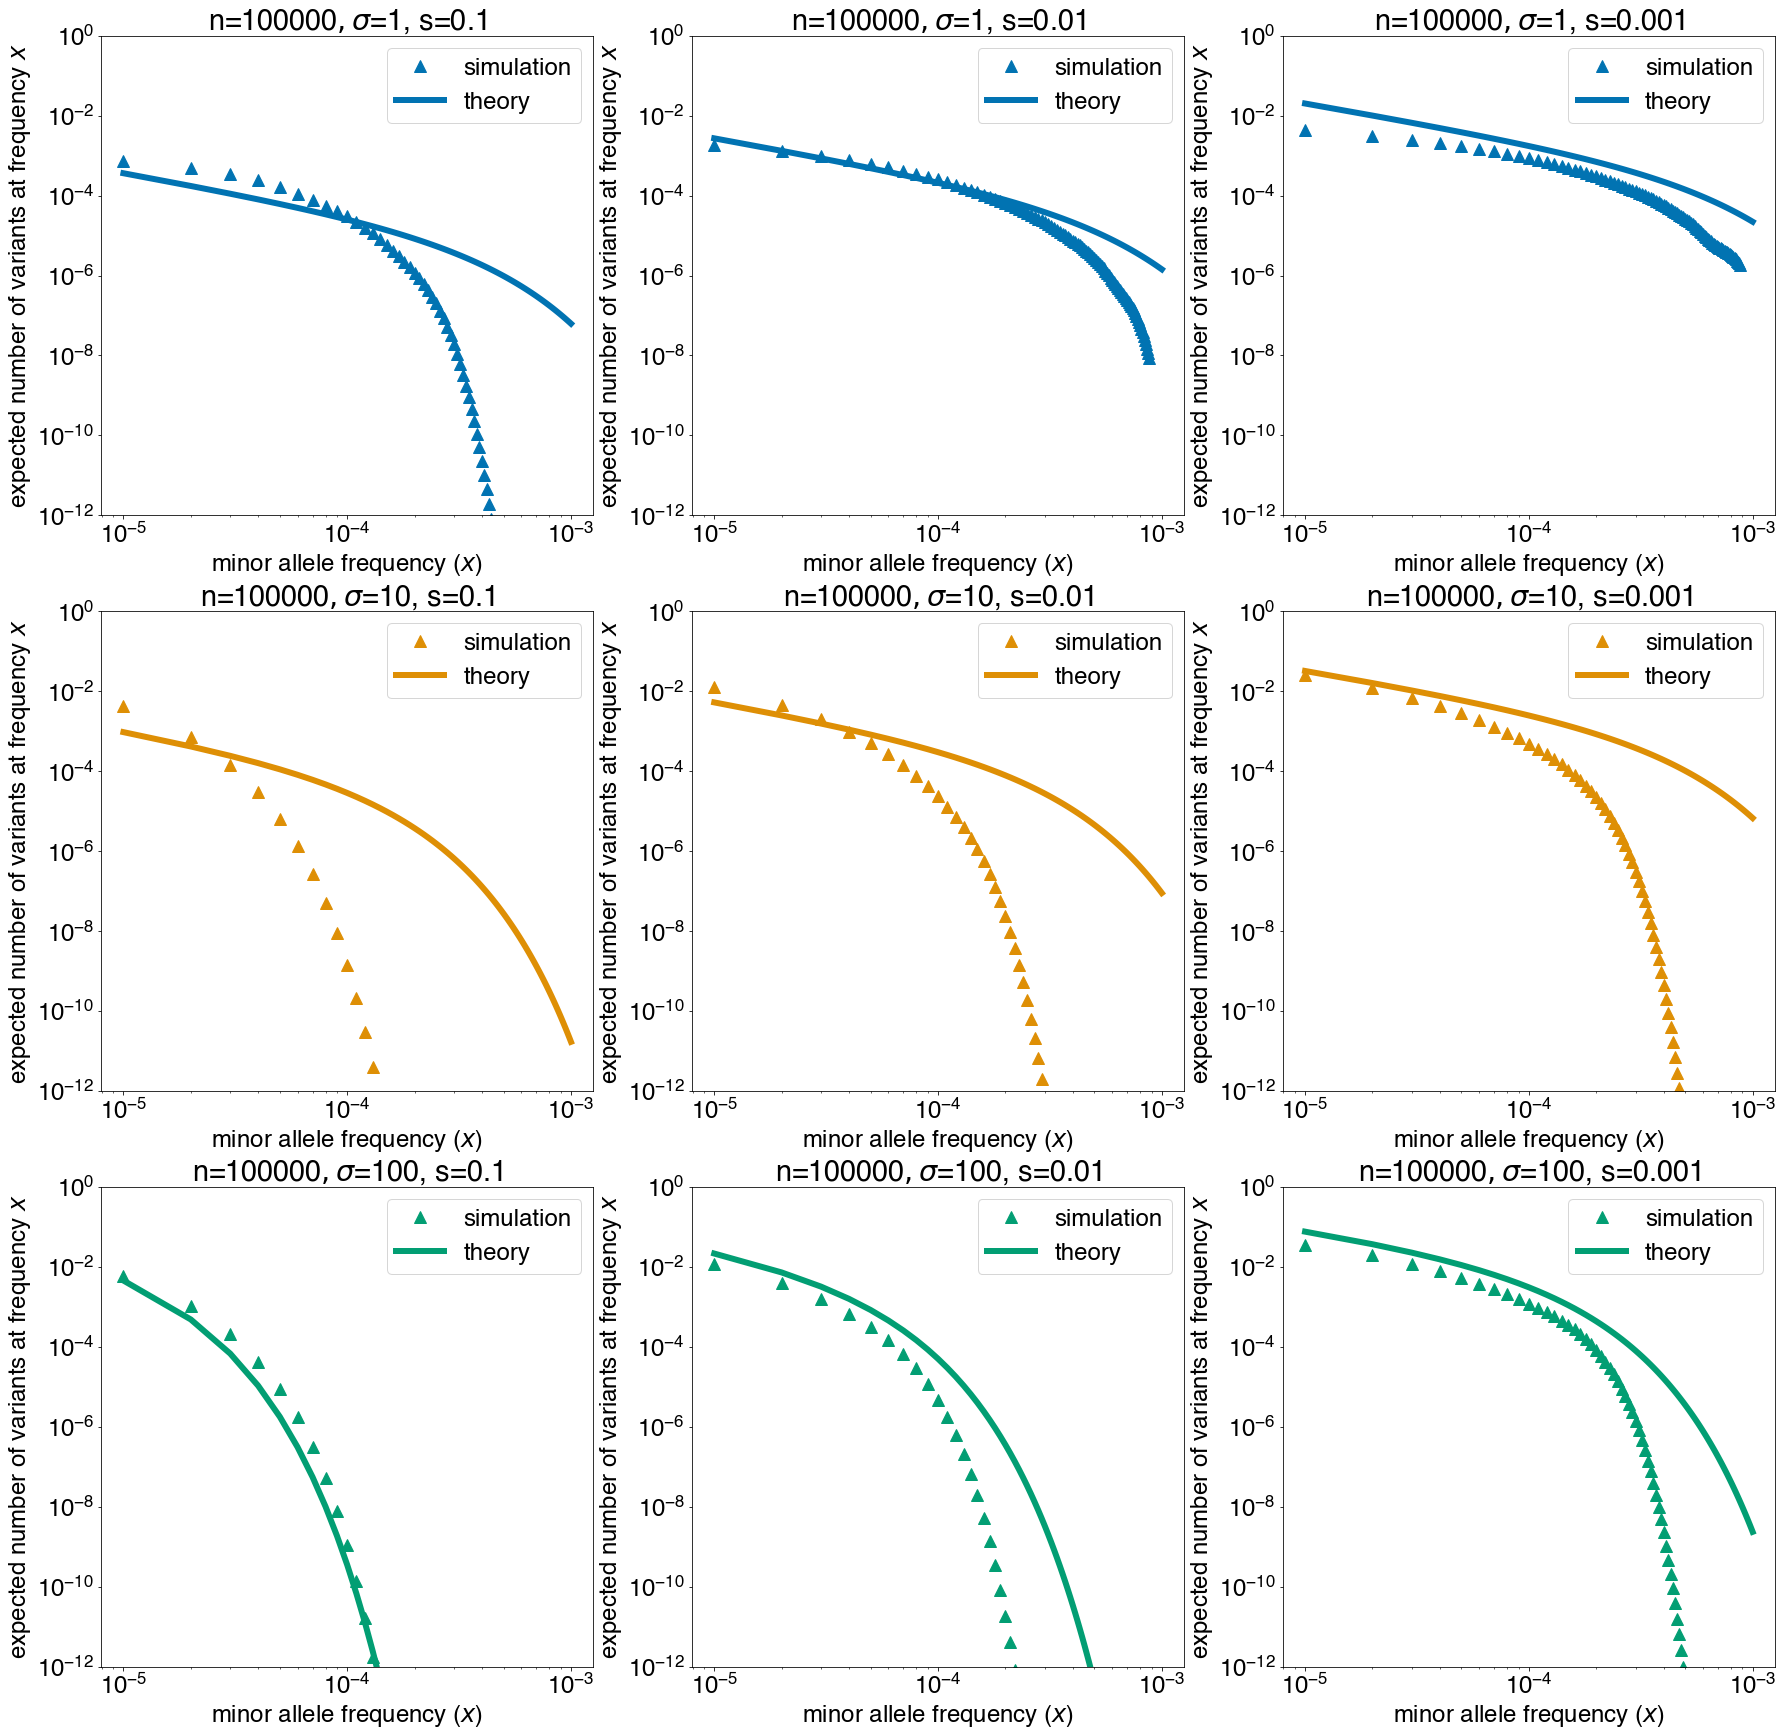

In [6]:
n = 100000 # getting overflow errors with larger n

plt.rcParams.update({'figure.figsize': '30,30'})
fig,ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        sim_output = simulate_WF(m,dims,Nb,s_vals[j],num_intervals)
        counts, sfs_sim = get_sfs(f=sim_output,sigma=sg[i],n=n,nbins=nmax)
        counts_ab = counts[0:100]
        sfs_theory = [finite_sfs_k(n,k,sg[i],s_vals[j],sigma_vals,pole_vals,res_vals,dens=rho,D=D,mu=mu) for k in counts_ab]    
        ax[i,j].plot(counts_ab/n,sfs_sim,label="simulation",marker='^',linestyle='None',color=colors[i])
        ax[i,j].plot(counts_ab/n,sfs_theory,label="theory",color=colors[i])
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        ax[i,j].set_ylim(1e-12,1e0)
        ax[i,j].set_title("n="+str(n)+r"$, \sigma$="+str(sg[i])+", s="+str(s_vals[j]))
        ax[i,j].set_xlabel(r"minor allele frequency ($x$)")
        ax[i,j].set_ylabel(r"expected number of variants at frequency $x$")
        ax[i,j].legend()
plt.savefig("plots_20230426/theory_vs_sims_n"+str(n)+".png")
plt.show()

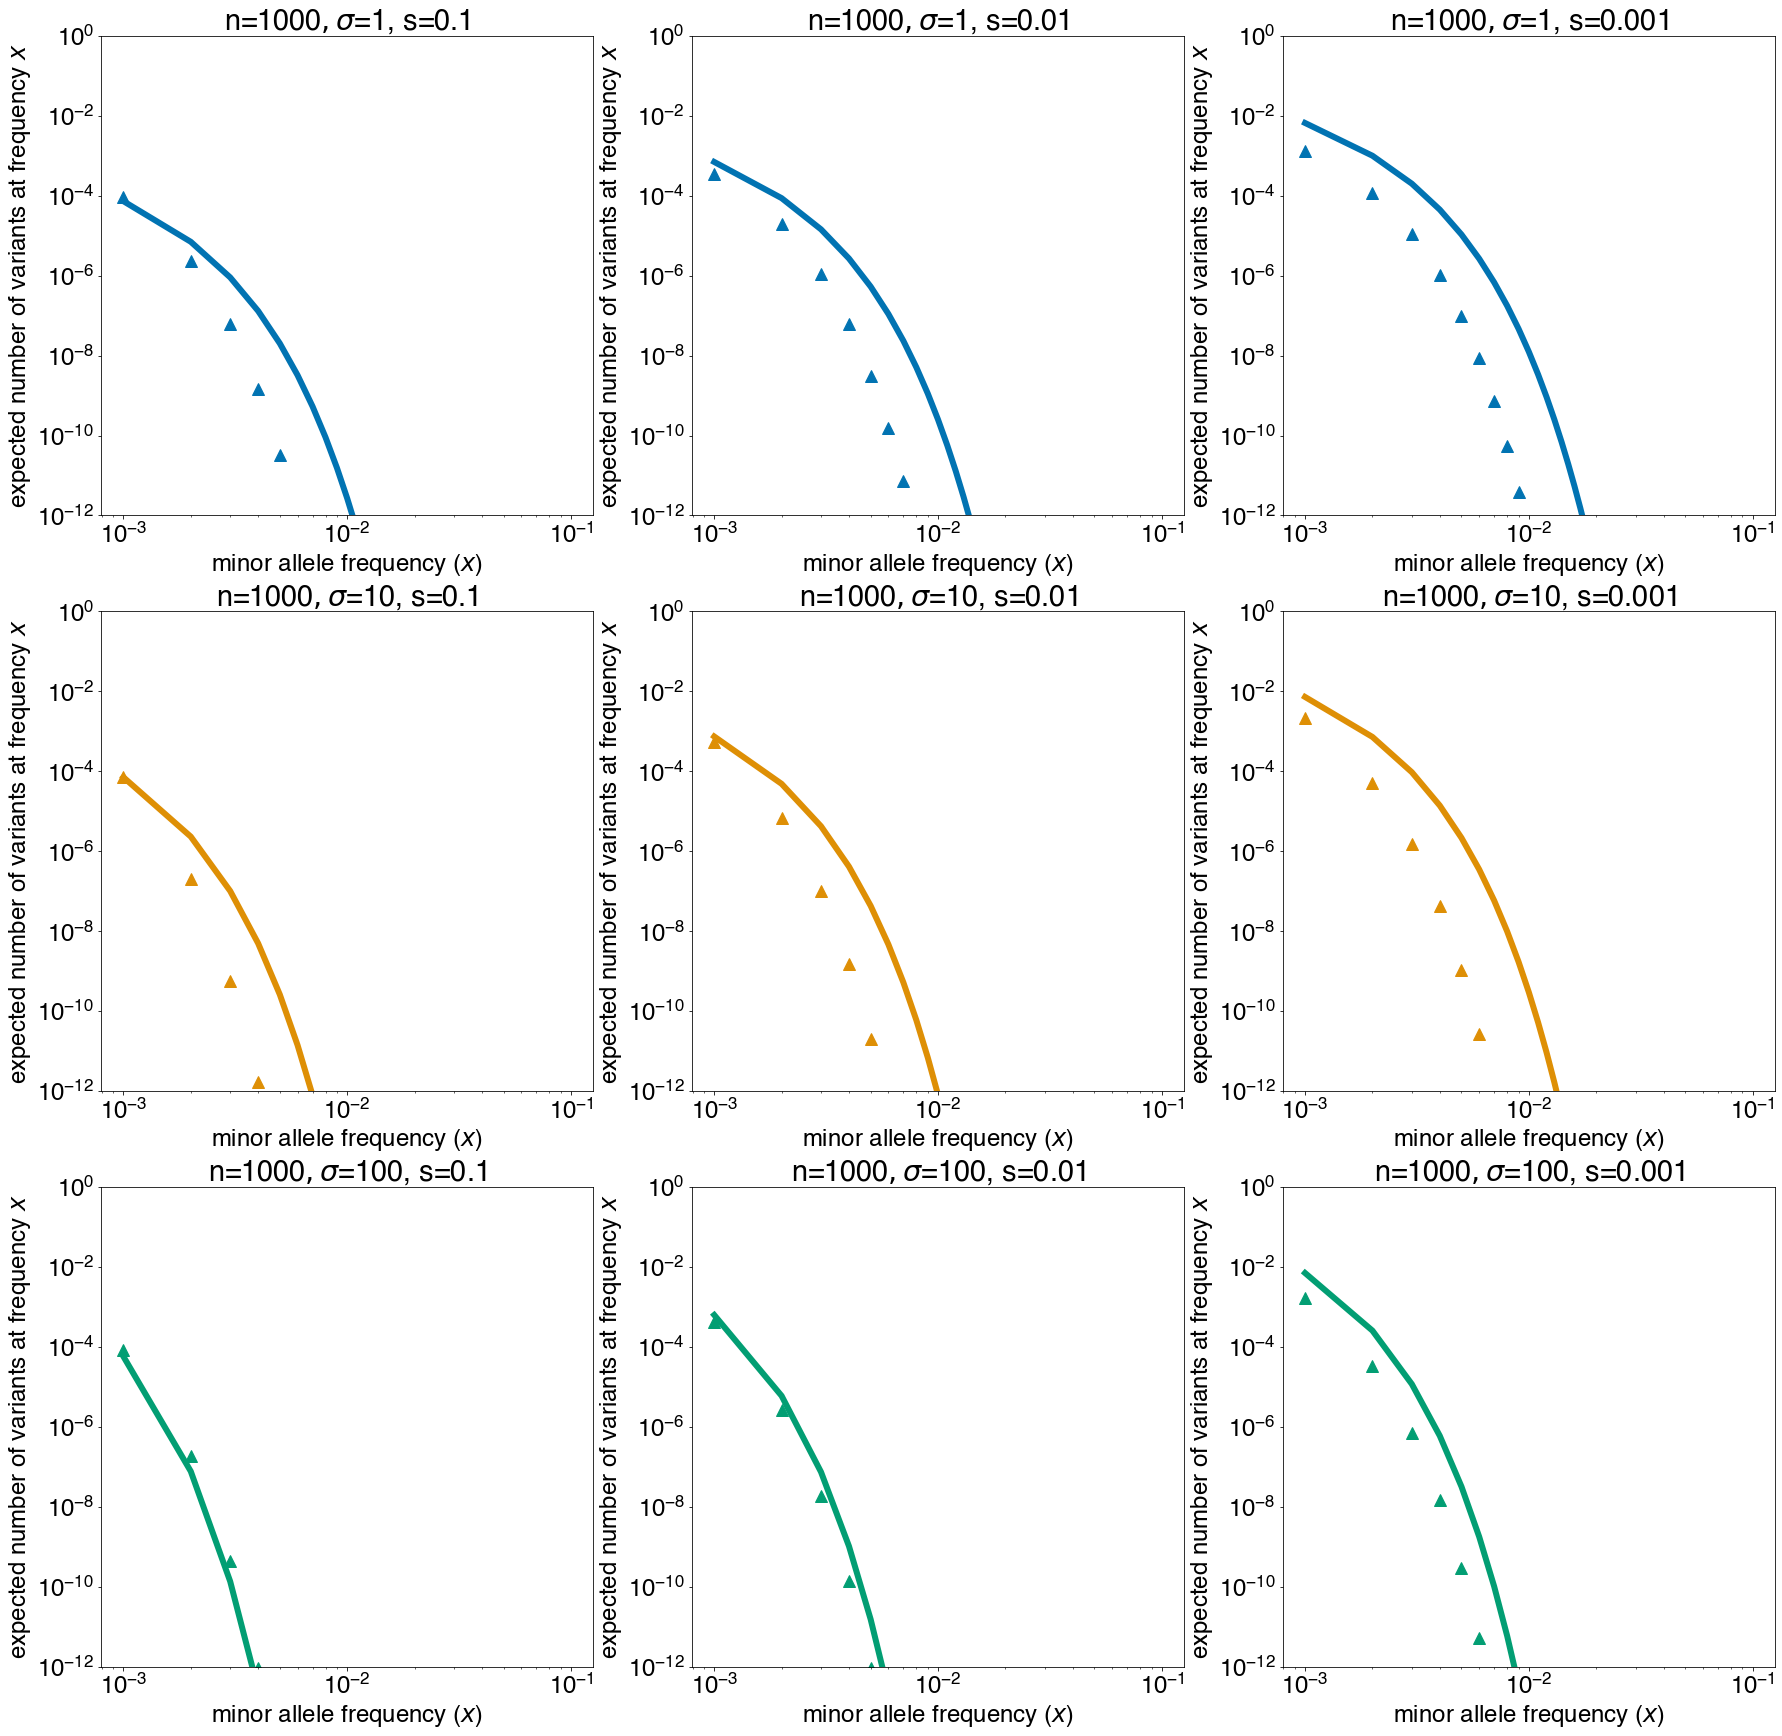

In [7]:
n = 1000

plt.rcParams.update({'figure.figsize': '30,30'})
fig,ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        sim_output = simulate_WF(m,dims,Nb,s_vals[j],num_intervals)
        counts, sfs_sim = get_sfs(f=sim_output,sigma=sg[i],n=n,nbins=nmax)
        counts_ab = counts[0:100]
        sfs_theory = [finite_sfs_k(n,k,sg[i],s_vals[j],sigma_vals,pole_vals,res_vals,dens=rho,D=D,mu=mu) for k in counts_ab]    
        ax[i,j].plot(counts_ab/n,sfs_sim,label="simulation",marker='^',linestyle='None',color=colors[i])
        ax[i,j].plot(counts_ab/n,sfs_theory,label="theory",color=colors[i])
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        ax[i,j].set_ylim(1e-12,1e0)
        ax[i,j].set_title("n="+str(n)+r"$, \sigma$="+str(sg[i])+", s="+str(s_vals[j]))
        ax[i,j].set_xlabel(r"minor allele frequency ($x$)")
        ax[i,j].set_ylabel(r"expected number of variants at frequency $x$")
plt.savefig("plots_20230426/theory_vs_sims_n"+str(n)+".png")
plt.show()

<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipyth

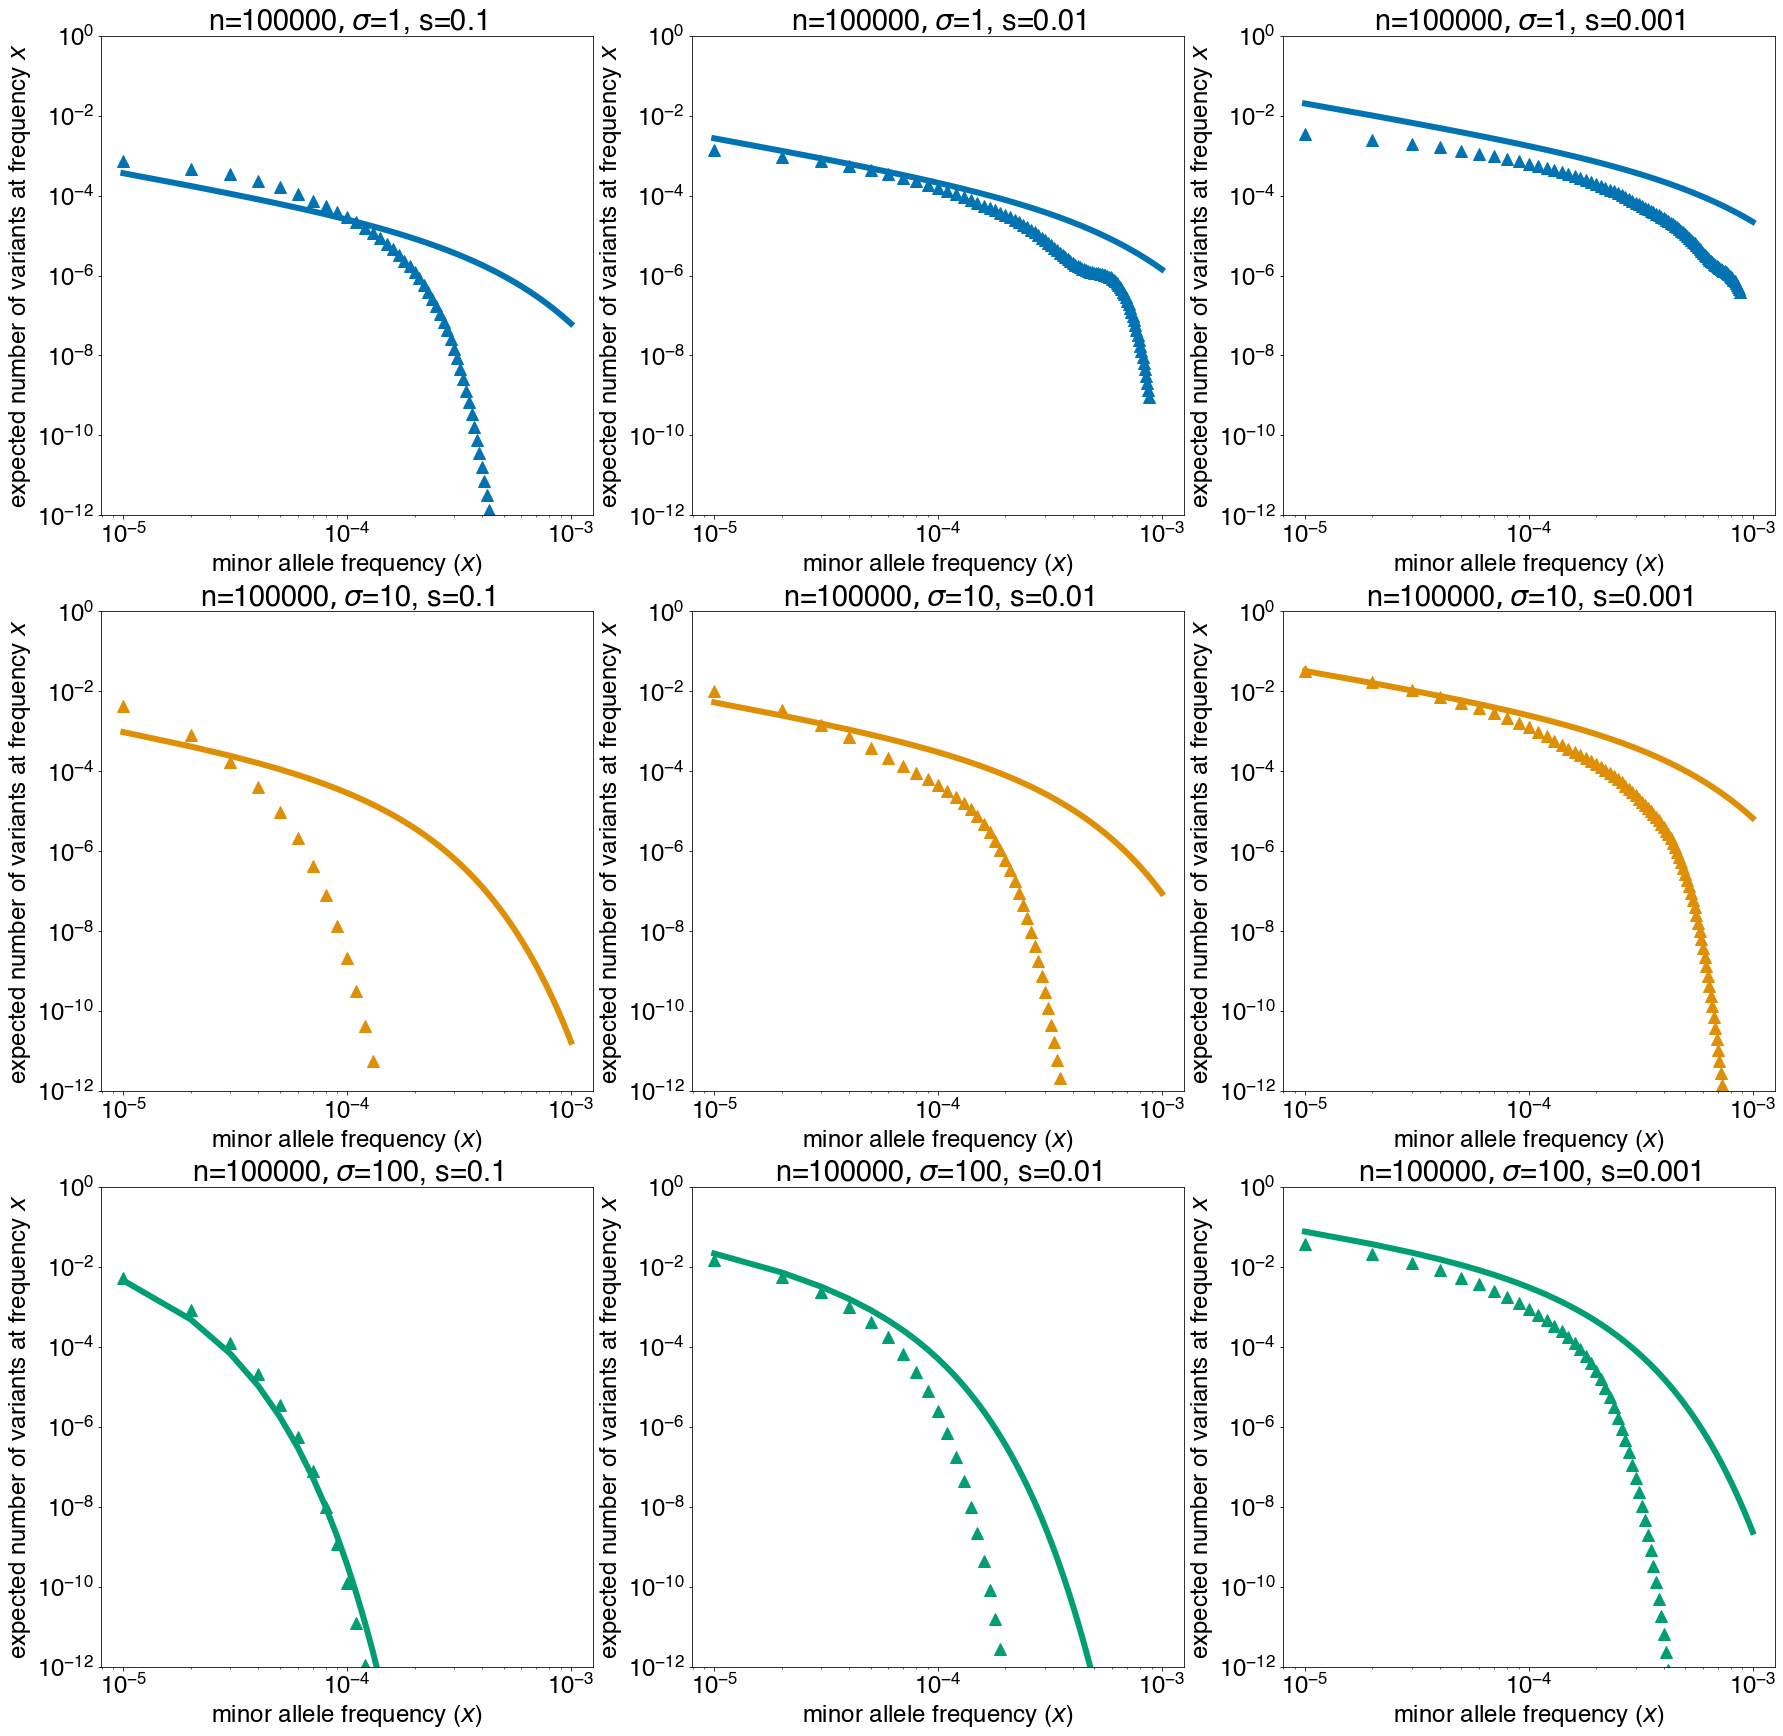

In [8]:
n = 100000

plt.rcParams.update({'figure.figsize': '30,30'})
fig,ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        sim_output = simulate_WF(m,dims,Nb,s_vals[j],num_intervals)
        counts, sfs_sim = get_sfs(f=sim_output,sigma=sg[i],n=n,nbins=nmax)
        counts_ab = counts[0:100]
        sfs_theory = [finite_sfs_k(n,k,sg[i],s_vals[j],sigma_vals,pole_vals,res_vals,dens=rho,D=D,mu=mu) for k in counts_ab]    
        ax[i,j].plot(counts_ab/n,sfs_sim,label="simulation",marker='^',linestyle='None',color=colors[i])
        ax[i,j].plot(counts_ab/n,sfs_theory,label="theory",color=colors[i])
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        ax[i,j].set_ylim(1e-12,1e0)
        ax[i,j].set_title("n="+str(n)+r"$, \sigma$="+str(sg[i])+", s="+str(s_vals[j]))
        ax[i,j].set_xlabel(r"minor allele frequency ($x$)")
        ax[i,j].set_ylabel(r"expected number of variants at frequency $x$")
plt.savefig("plots_20230426/theory_vs_sims_n"+str(n)+".png")
plt.show()

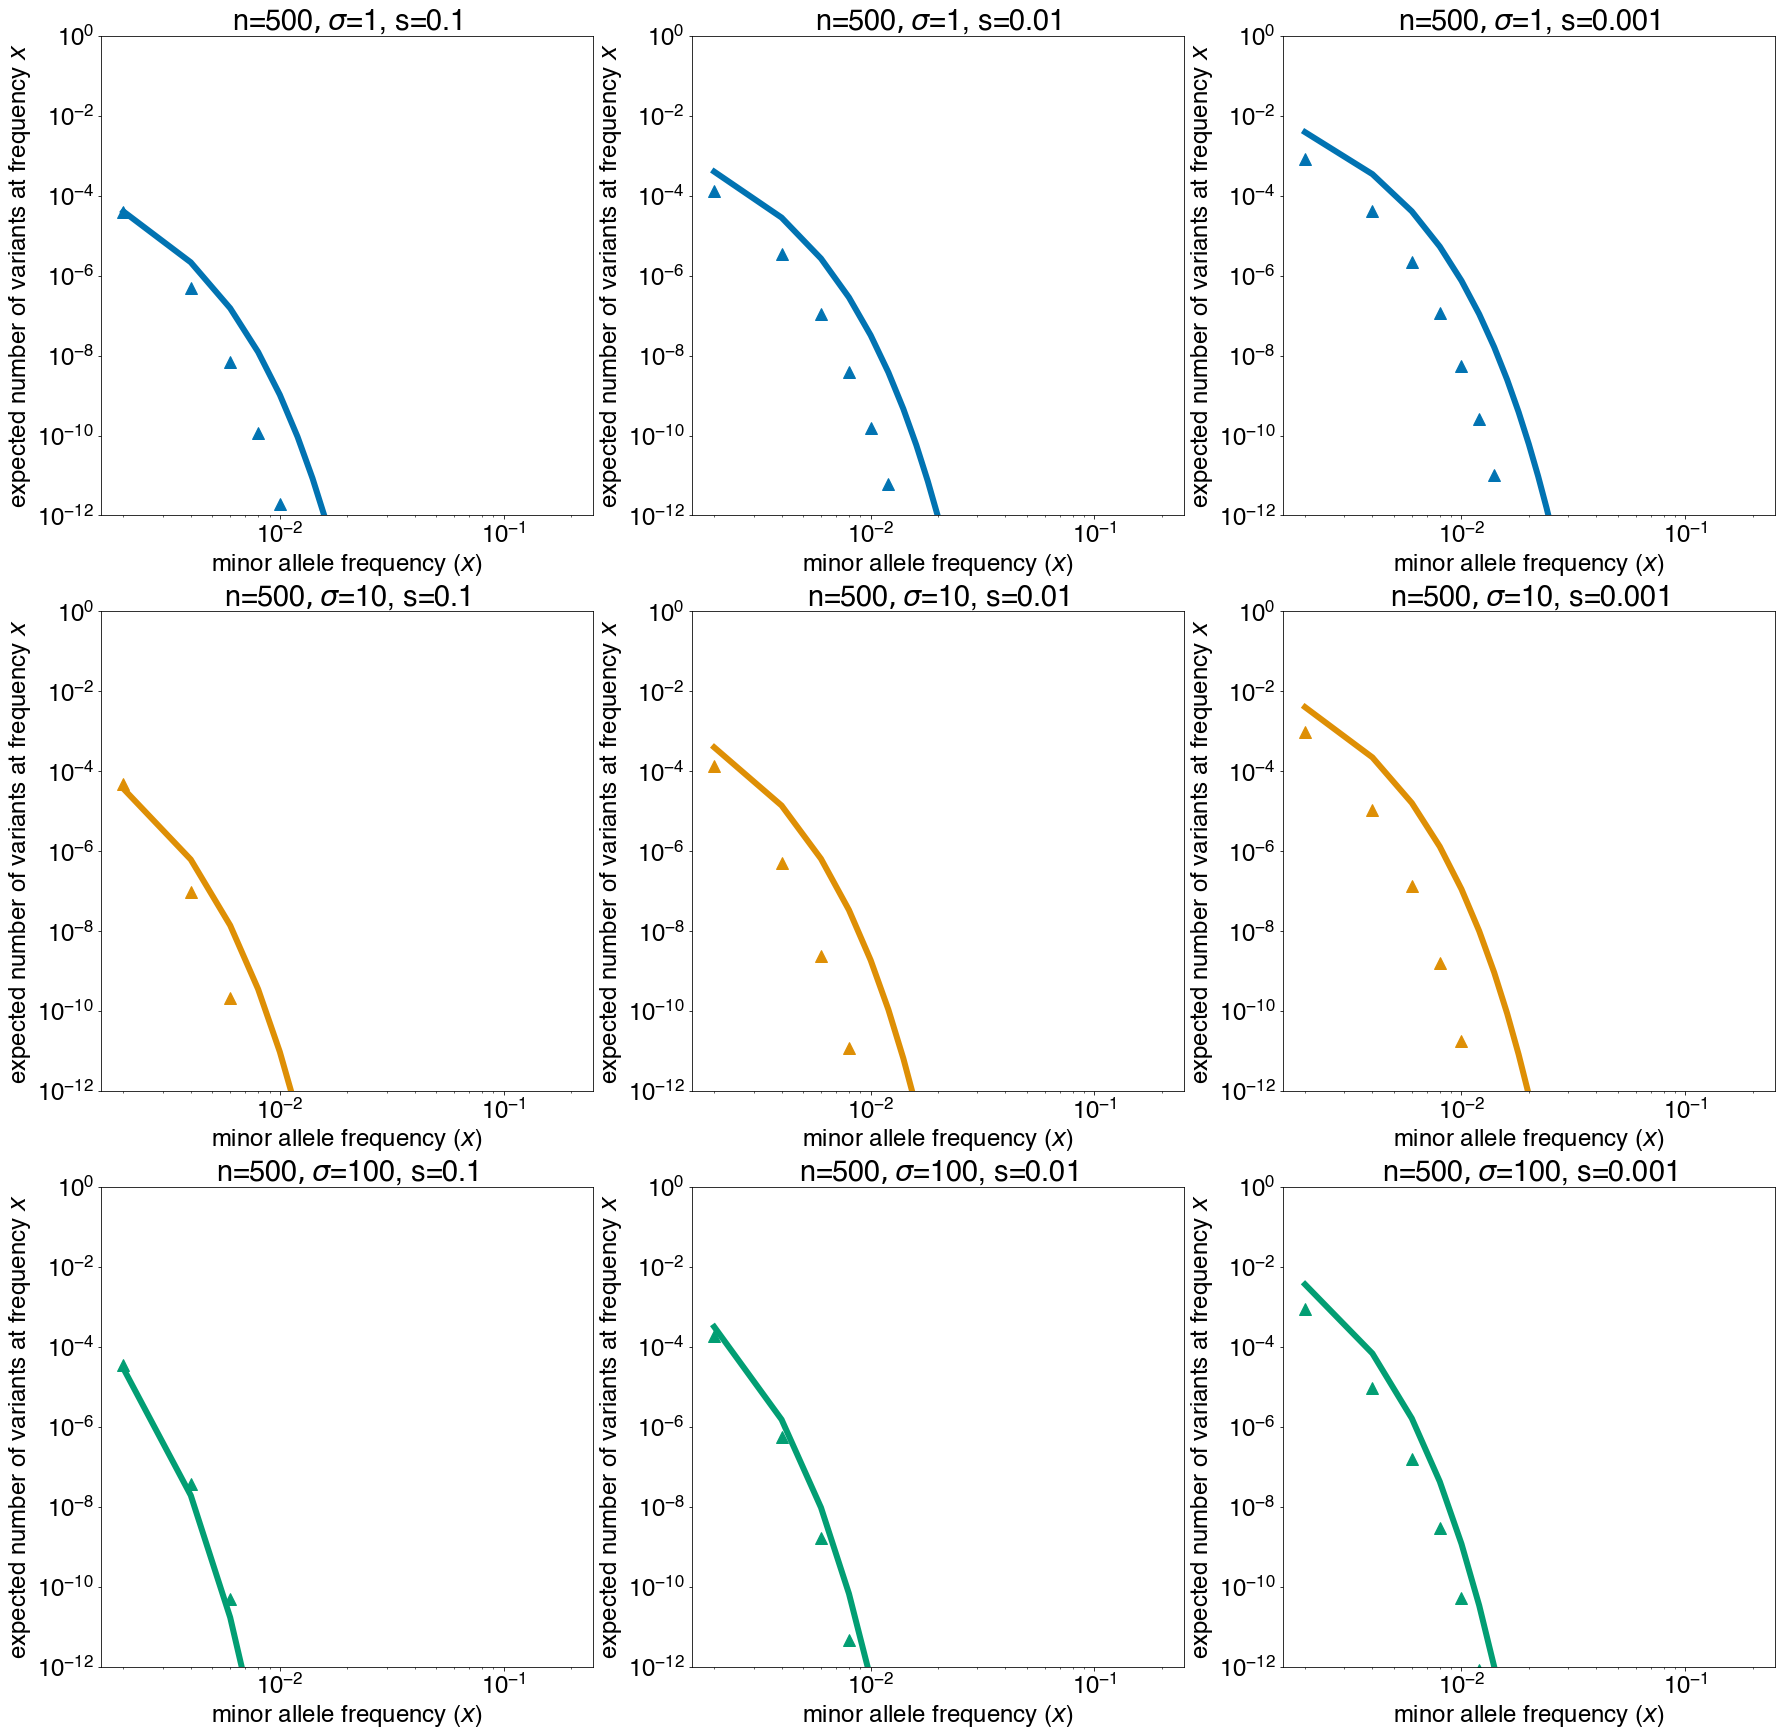

In [9]:
n = 500

plt.rcParams.update({'figure.figsize': '30,30'})
fig,ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        sim_output = simulate_WF(m,dims,Nb,s_vals[j],num_intervals)
        counts, sfs_sim = get_sfs(f=sim_output,sigma=sg[i],n=n,nbins=nmax)
        counts_ab = counts[0:100]
        sfs_theory = [finite_sfs_k(n,k,sg[i],s_vals[j],sigma_vals,pole_vals,res_vals,dens=rho,D=D,mu=mu) for k in counts_ab]    
        ax[i,j].plot(counts_ab/n,sfs_sim,label="simulation",marker='^',linestyle='None',color=colors[i])
        ax[i,j].plot(counts_ab/n,sfs_theory,label="theory",color=colors[i])
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        ax[i,j].set_ylim(1e-12,1e0)
        ax[i,j].set_title("n="+str(n)+r"$, \sigma$="+str(sg[i])+", s="+str(s_vals[j]))
        ax[i,j].set_xlabel(r"minor allele frequency ($x$)")
        ax[i,j].set_ylabel(r"expected number of variants at frequency $x$")
plt.savefig("plots_20230426/theory_vs_sims_n"+str(n)+".png")
plt.show()

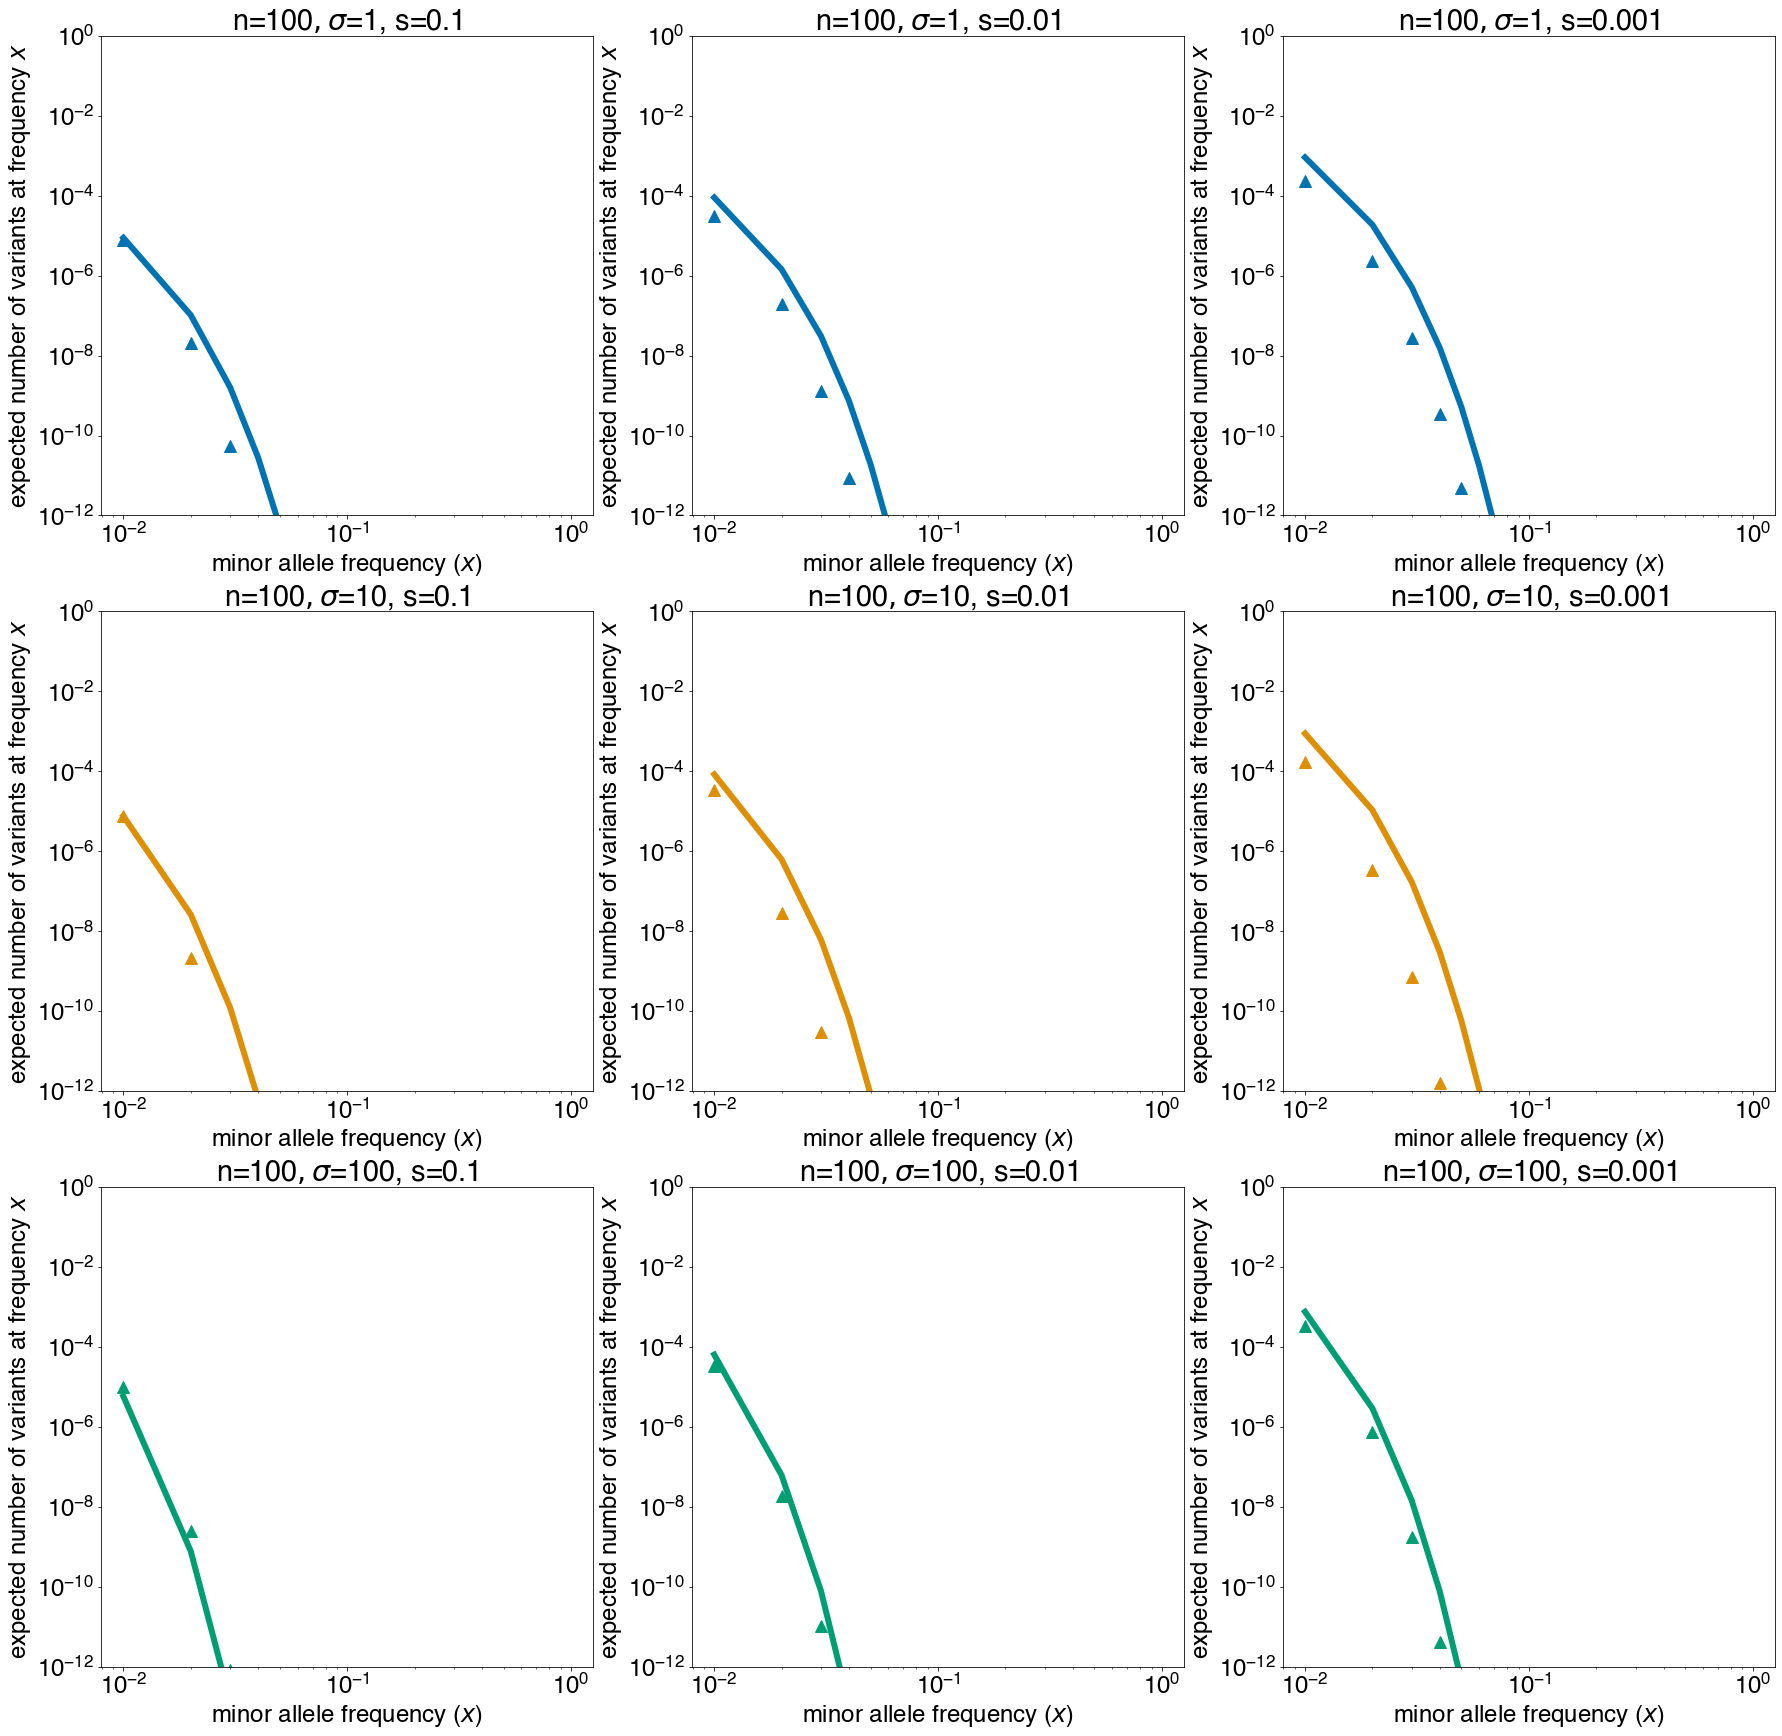

In [10]:
n = 100

plt.rcParams.update({'figure.figsize': '30,30'})
fig,ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        sim_output = simulate_WF(m,dims,Nb,s_vals[j],num_intervals)
        counts, sfs_sim = get_sfs(f=sim_output,sigma=sg[i],n=n,nbins=nmax)
        counts_ab = counts[0:100]
        sfs_theory = [finite_sfs_k(n,k,sg[i],s_vals[j],sigma_vals,pole_vals,res_vals,dens=rho,D=D,mu=mu) for k in counts_ab]    
        ax[i,j].plot(counts_ab/n,sfs_sim,label="simulation",marker='^',linestyle='None',color=colors[i])
        ax[i,j].plot(counts_ab/n,sfs_theory,label="theory",color=colors[i])
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        ax[i,j].set_ylim(1e-12,1e0)
        ax[i,j].set_title("n="+str(n)+r"$, \sigma$="+str(sg[i])+", s="+str(s_vals[j]))
        ax[i,j].set_xlabel(r"minor allele frequency ($x$)")
        ax[i,j].set_ylabel(r"expected number of variants at frequency $x$")
plt.savefig("plots_20230426/theory_vs_sims_n"+str(n)+".png")
plt.show()

### Qualitative results still hold in simulations

dilution for small $n$, discovery & dilution for high $n$

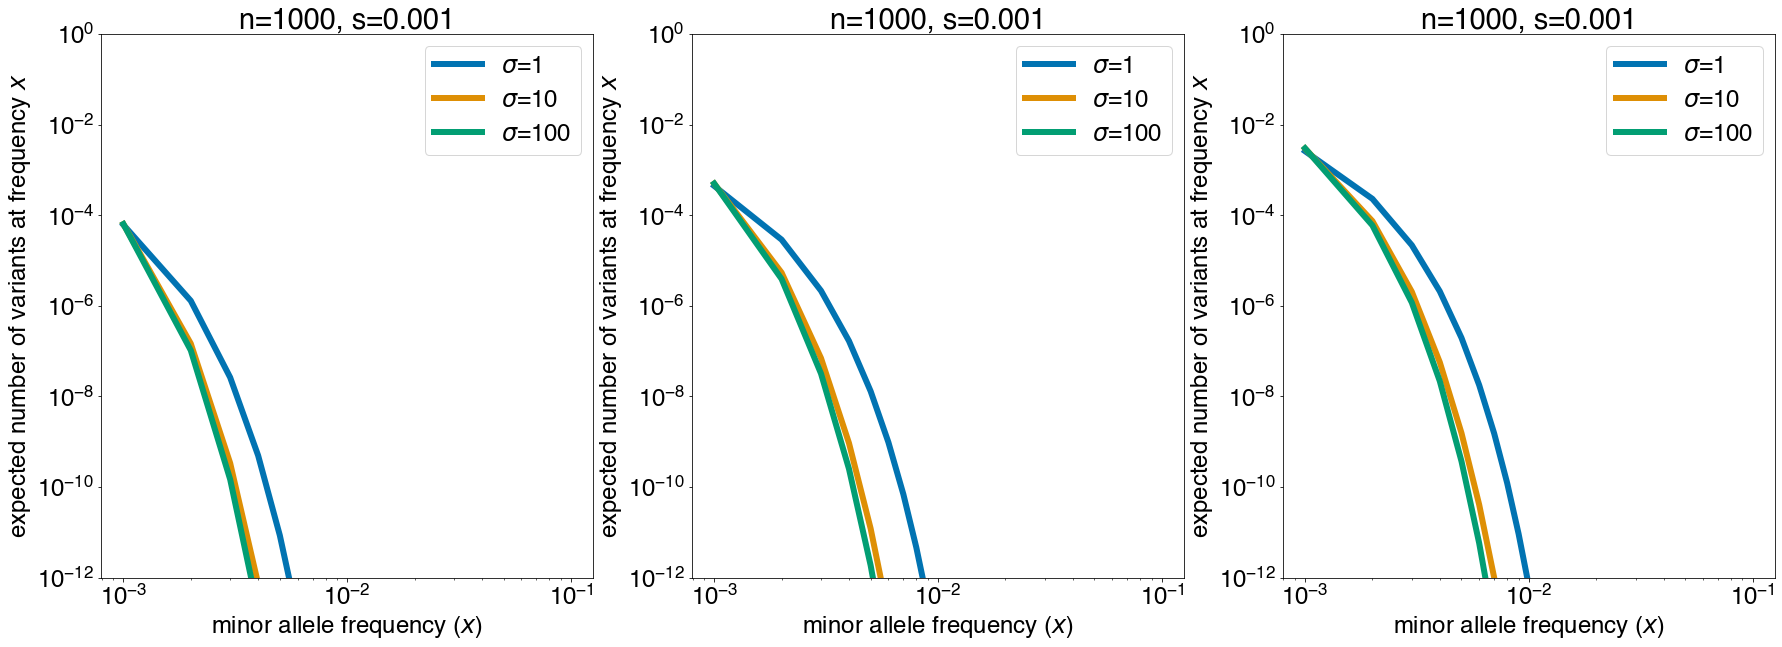

In [11]:
n = 1000
plt.rcParams.update({'figure.figsize': '30,10'})
fig,ax = plt.subplots(1,3)
for i in range(3):
    sim_output = simulate_WF(m,dims,Nb,s_vals[i],num_intervals)
    for j in range(3):
        counts, sfs_sim = get_sfs(f=sim_output,sigma=sg[j],n=n,nbins=nmax)
        counts_ab = counts[0:100]
        ax[i].plot(counts_ab/n,sfs_sim,label=r"$\sigma$="+str(sg[j]),color=colors[j])
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        ax[i].set_ylim(1e-12,1e0)
        ax[i].set_title("n="+str(n)+", s="+str(s_vals[j]))
        ax[i].legend()
        ax[i].set_xlabel(r"minor allele frequency ($x$)")
        ax[i].set_ylabel(r"expected number of variants at frequency $x$")
plt.savefig("plots_20230426/sims_sigma_n"+str(n)+".png")
plt.show()

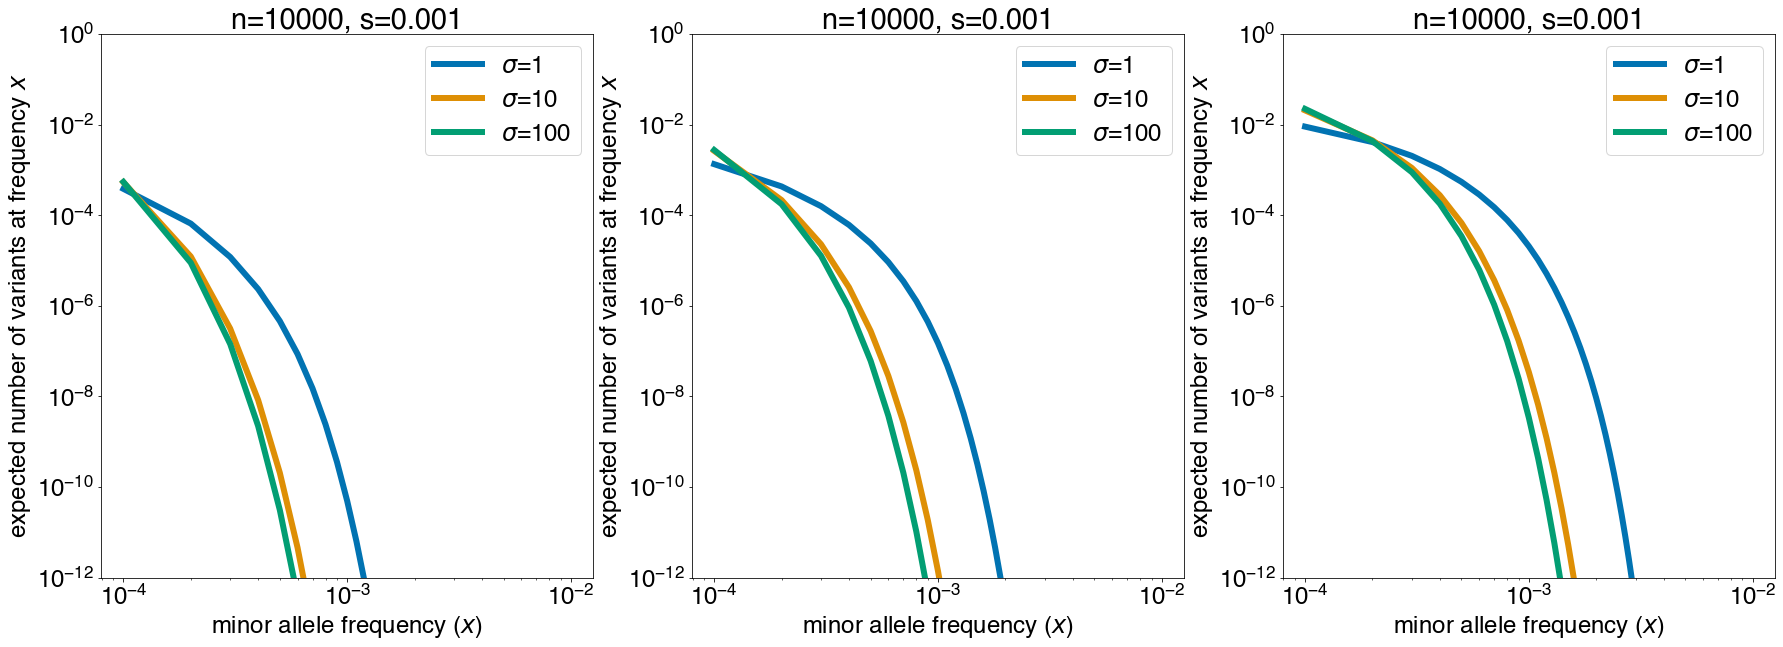

In [12]:
n = 10000
plt.rcParams.update({'figure.figsize': '30,10'})
fig,ax = plt.subplots(1,3)
for i in range(3):
    sim_output = simulate_WF(m,dims,Nb,s_vals[i],num_intervals)
    for j in range(3):
        counts, sfs_sim = get_sfs(f=sim_output,sigma=sg[j],n=n,nbins=nmax)
        counts_ab = counts[0:100]
        ax[i].plot(counts_ab/n,sfs_sim,label=r"$\sigma$="+str(sg[j]),color=colors[j])
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        ax[i].set_ylim(1e-12,1e0)
        ax[i].set_title("n="+str(n)+", s="+str(s_vals[j]))
        ax[i].legend()
        ax[i].set_xlabel(r"minor allele frequency ($x$)")
        ax[i].set_ylabel(r"expected number of variants at frequency $x$")
plt.savefig("plots_20230426/sims_sigma_n"+str(n)+".png")
plt.show()
        

<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipython-input-2-3ba660f3a889>:62: RuntimeWarning: invalid value encountered in multiply
  sfs[j] = binom(n, j) * f ** j * (1 - f) ** (n - j)
<ipyth

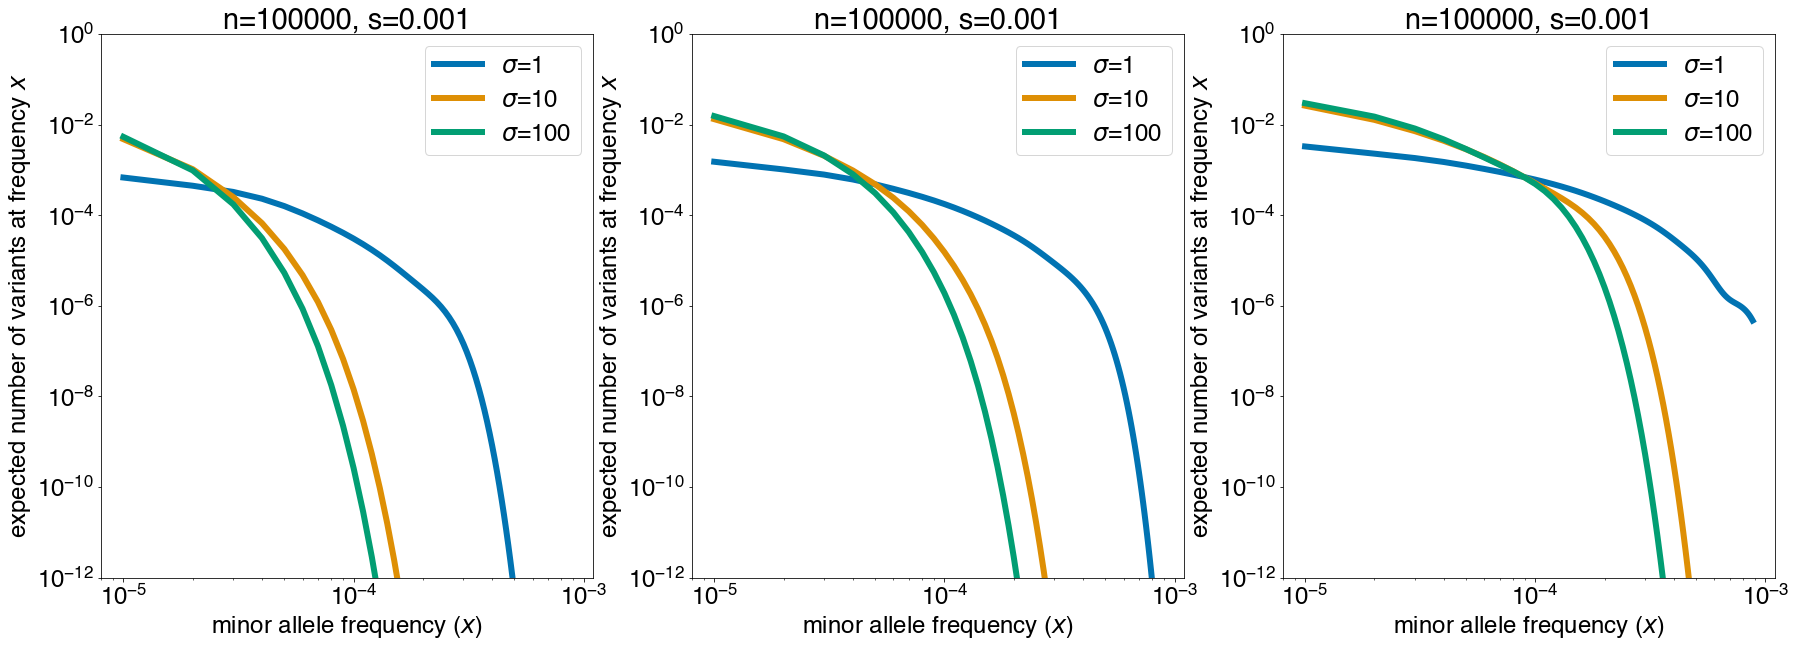

In [13]:
n = 100000
plt.rcParams.update({'figure.figsize': '30,10'})
fig,ax = plt.subplots(1,3)
for i in range(3):
    sim_output = simulate_WF(m,dims,Nb,s_vals[i],num_intervals)
    for j in range(3):
        counts, sfs_sim = get_sfs(f=sim_output,sigma=sg[j],n=n,nbins=nmax)
        counts_ab = counts[0:100]
        ax[i].plot(counts_ab/n,sfs_sim,label=r"$\sigma$="+str(sg[j]),color=colors[j])
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        ax[i].set_ylim(1e-12,1e0)
        ax[i].set_title("n="+str(n)+", s="+str(s_vals[j]))
        ax[i].legend()
        ax[i].set_xlabel(r"minor allele frequency ($x$)")
        ax[i].set_ylabel(r"expected number of variants at frequency $x$")
plt.savefig("plots_20230426/sims_sigma_n"+str(n)+".png")
plt.show()
        

Note: numerical issues leading to warnings for high-frequency cases, causes odd shape in right-most panel above 